# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|████████████████████████████████████████████████████████| 60.0K/60.0K [00:30<00:00, 1.98KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

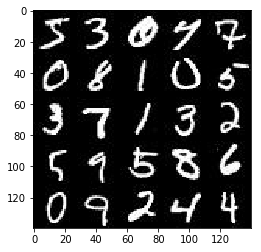

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

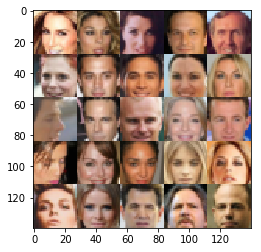

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [17]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, (None))
    return inputs_real, inputs_z, learning_rate

    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    alpha = 0.2
    i = images
    with tf.variable_scope('discriminator', reuse=reuse):
        i = tf.layers.conv2d(i, 64, 4, strides=2, padding="same")
        i = tf.layers.batch_normalization(i, training=True)
        i = tf.maximum(alpha * i, i)
        

        i = tf.layers.conv2d(i, 128, 4, strides=2, padding="same")
        i = tf.layers.batch_normalization(i, training=True)
        i = tf.maximum(alpha * i, i)
       

        i = tf.layers.conv2d(i, 256, 4, strides=2, padding="same")
        i = tf.layers.batch_normalization(i, training=True)
        i = tf.maximum(alpha * i, i)
       

        i = tf.reshape(i, (-1, 4*4*256))
        logits = tf.layers.dense(i, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [18]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    reuse = not is_train
    alpha=0.2
    with tf.variable_scope('generator', reuse=reuse):
        x = tf.layers.dense(z, 4*4*512) 
        x = tf.reshape(x, (-1,4,4,512))
        x = tf.layers.batch_normalization(x,training=is_train)
        x = tf.maximum(alpha * x, x)
       
        x = tf.layers.conv2d_transpose(x, 256, 4, strides=1, padding="valid")
        x = tf.layers.batch_normalization(x,training=is_train)
        x = tf.maximum(alpha * x, x)
    
        x = tf.layers.conv2d_transpose(x, 128, 4, strides=2, padding="same")
        x = tf.layers.batch_normalization(x,training=is_train)
        x = tf.maximum(alpha * x, x)
      
        x = tf.layers.conv2d_transpose(x, out_channel_dim, 4, strides=2, padding="same")
        

        logits = x
        out = tf.tanh(logits)
       

    return out
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [19]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = 0.1
    _, d_logits_real = discriminator(input_real, reuse=False)
    fake = generator(input_z, out_channel_dim, is_train=True)
   
    d_logits_fake = discriminator(fake, reuse=True)
    
    d_loss_real = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                              labels=tf.ones_like(d_logits_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                              labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
                 tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                         labels=tf.ones_like(d_logits_fake)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [20]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]

    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [21]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [25]:
import time
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    
    inputs_real, inputs_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[-1])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    step = 0 
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                start_time = time.time()
                step = step+1
                batch_images = batch_images * 2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={inputs_z: batch_z, lr:learning_rate})
                
                if step % 100 == 0:
                    train_loss_d = d_loss.eval({inputs_z:batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z:batch_z})
                    print("Epoch {}/{} Step {}...".format(epoch_i+1, epoch_count, step),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g),
                      "... Time spent={:.4f}".format(time.time() - start_time))    

                if step % 200 == 0:
                    show_generator_output(sess, 25, inputs_z, data_shape[3], data_image_mode)
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 Step 100... Discriminator Loss: 1.1843... Generator Loss: 0.6982 ... Time spent=0.1955
Epoch 1/2 Step 200... Discriminator Loss: 1.4012... Generator Loss: 0.4522 ... Time spent=0.0907


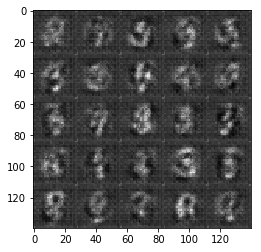

Epoch 1/2 Step 300... Discriminator Loss: 1.2643... Generator Loss: 0.5404 ... Time spent=0.0937
Epoch 1/2 Step 400... Discriminator Loss: 1.5122... Generator Loss: 0.3954 ... Time spent=0.0842


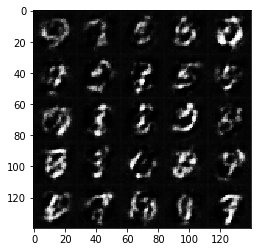

Epoch 1/2 Step 500... Discriminator Loss: 1.1339... Generator Loss: 1.2797 ... Time spent=0.1003
Epoch 1/2 Step 600... Discriminator Loss: 1.1334... Generator Loss: 0.6730 ... Time spent=0.0855


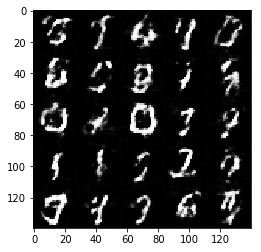

Epoch 2/2 Step 700... Discriminator Loss: 1.2859... Generator Loss: 0.5215 ... Time spent=0.1000
Epoch 2/2 Step 800... Discriminator Loss: 1.8789... Generator Loss: 0.2815 ... Time spent=0.1002


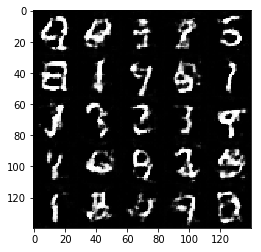

Epoch 2/2 Step 900... Discriminator Loss: 1.3438... Generator Loss: 0.4891 ... Time spent=0.1007
Epoch 2/2 Step 1000... Discriminator Loss: 1.4561... Generator Loss: 0.4235 ... Time spent=0.0917


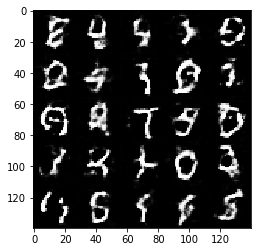

Epoch 2/2 Step 1100... Discriminator Loss: 1.1803... Generator Loss: 1.0891 ... Time spent=0.1036
Epoch 2/2 Step 1200... Discriminator Loss: 1.2836... Generator Loss: 0.5290 ... Time spent=0.1003


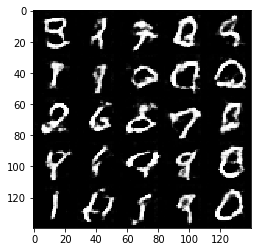

In [12]:
batch_size = 100
z_dim = 100
learning_rate = .0001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/5 Step 100... Discriminator Loss: 2.0149... Generator Loss: 0.3085 ... Time spent=0.1855
Epoch 1/5 Step 200... Discriminator Loss: 1.7077... Generator Loss: 0.3551 ... Time spent=0.0922


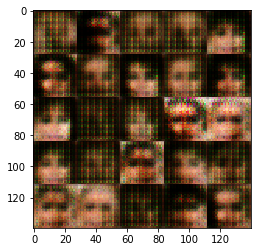

Epoch 1/5 Step 300... Discriminator Loss: 1.2202... Generator Loss: 0.9351 ... Time spent=0.1172
Epoch 1/5 Step 400... Discriminator Loss: 1.3395... Generator Loss: 0.6364 ... Time spent=0.1003


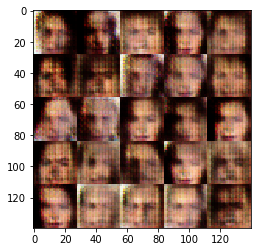

Epoch 1/5 Step 500... Discriminator Loss: 1.4089... Generator Loss: 0.6137 ... Time spent=0.1003
Epoch 1/5 Step 600... Discriminator Loss: 1.3483... Generator Loss: 0.8325 ... Time spent=0.0998


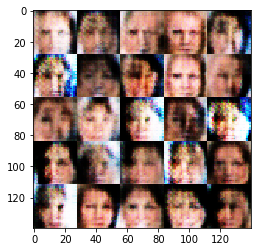

Epoch 1/5 Step 700... Discriminator Loss: 1.3967... Generator Loss: 0.6439 ... Time spent=0.1053
Epoch 1/5 Step 800... Discriminator Loss: 1.4536... Generator Loss: 0.8216 ... Time spent=0.1043


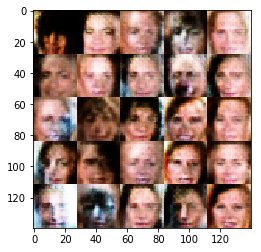

Epoch 1/5 Step 900... Discriminator Loss: 1.3636... Generator Loss: 0.7593 ... Time spent=0.1157
Epoch 1/5 Step 1000... Discriminator Loss: 1.3592... Generator Loss: 0.5425 ... Time spent=0.1126


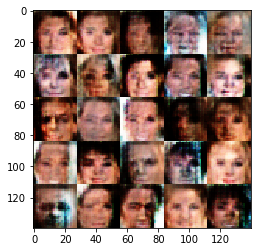

Epoch 1/5 Step 1100... Discriminator Loss: 1.4162... Generator Loss: 0.5367 ... Time spent=0.0946
Epoch 1/5 Step 1200... Discriminator Loss: 1.3245... Generator Loss: 0.9641 ... Time spent=0.0971


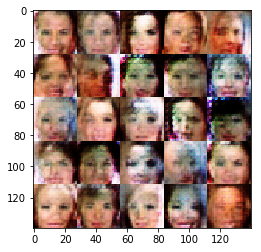

Epoch 1/5 Step 1300... Discriminator Loss: 1.6706... Generator Loss: 0.8656 ... Time spent=0.1087
Epoch 1/5 Step 1400... Discriminator Loss: 1.3237... Generator Loss: 0.5687 ... Time spent=0.0997


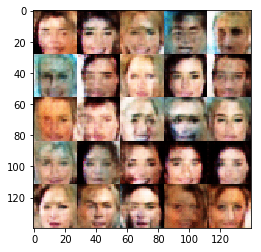

Epoch 1/5 Step 1500... Discriminator Loss: 1.6401... Generator Loss: 0.3538 ... Time spent=0.0983
Epoch 1/5 Step 1600... Discriminator Loss: 1.4829... Generator Loss: 0.4227 ... Time spent=0.0999


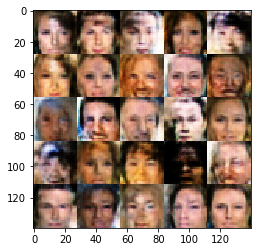

Epoch 1/5 Step 1700... Discriminator Loss: 1.4519... Generator Loss: 0.5357 ... Time spent=0.1114
Epoch 1/5 Step 1800... Discriminator Loss: 1.2902... Generator Loss: 0.6658 ... Time spent=0.1126


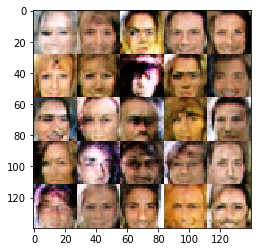

Epoch 1/5 Step 1900... Discriminator Loss: 1.4246... Generator Loss: 0.9550 ... Time spent=0.0936
Epoch 1/5 Step 2000... Discriminator Loss: 1.6091... Generator Loss: 1.1363 ... Time spent=0.1003


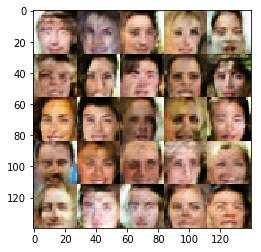

Epoch 2/5 Step 2100... Discriminator Loss: 1.4133... Generator Loss: 0.7088 ... Time spent=0.1029
Epoch 2/5 Step 2200... Discriminator Loss: 1.3604... Generator Loss: 0.9410 ... Time spent=0.0953


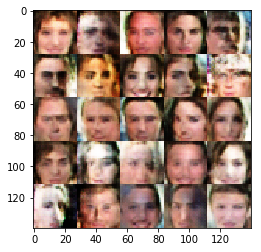

Epoch 2/5 Step 2300... Discriminator Loss: 1.5585... Generator Loss: 0.3935 ... Time spent=0.0998
Epoch 2/5 Step 2400... Discriminator Loss: 1.3738... Generator Loss: 0.6402 ... Time spent=0.1028


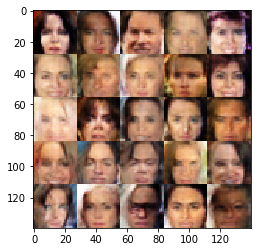

Epoch 2/5 Step 2500... Discriminator Loss: 1.3740... Generator Loss: 0.6431 ... Time spent=0.1135
Epoch 2/5 Step 2600... Discriminator Loss: 1.3409... Generator Loss: 0.6153 ... Time spent=0.0968


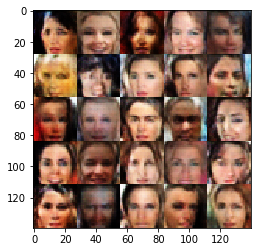

Epoch 2/5 Step 2700... Discriminator Loss: 1.4639... Generator Loss: 0.5134 ... Time spent=0.0903
Epoch 2/5 Step 2800... Discriminator Loss: 1.4659... Generator Loss: 0.5028 ... Time spent=0.1018


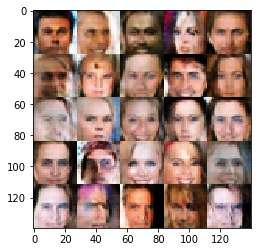

Epoch 2/5 Step 2900... Discriminator Loss: 1.4322... Generator Loss: 0.6629 ... Time spent=0.1076
Epoch 2/5 Step 3000... Discriminator Loss: 1.3872... Generator Loss: 0.6191 ... Time spent=0.1010


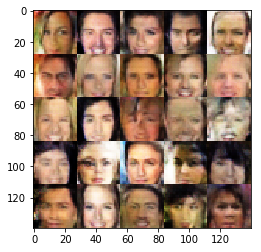

Epoch 2/5 Step 3100... Discriminator Loss: 1.4022... Generator Loss: 0.6090 ... Time spent=0.1161
Epoch 2/5 Step 3200... Discriminator Loss: 1.3894... Generator Loss: 0.7041 ... Time spent=0.1003


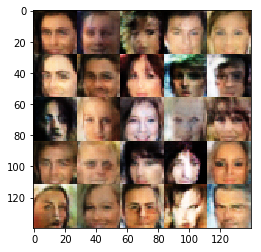

Epoch 2/5 Step 3300... Discriminator Loss: 1.3935... Generator Loss: 0.4880 ... Time spent=0.1311
Epoch 2/5 Step 3400... Discriminator Loss: 1.5049... Generator Loss: 0.4928 ... Time spent=0.0994


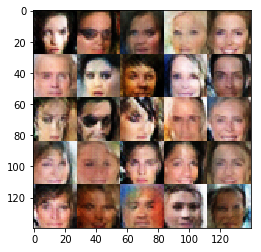

Epoch 2/5 Step 3500... Discriminator Loss: 1.5258... Generator Loss: 0.4194 ... Time spent=0.1143
Epoch 2/5 Step 3600... Discriminator Loss: 1.4486... Generator Loss: 0.5720 ... Time spent=0.1127


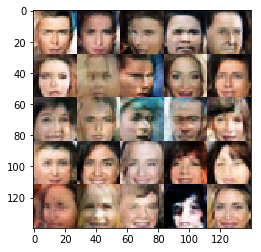

Epoch 2/5 Step 3700... Discriminator Loss: 1.5083... Generator Loss: 0.7414 ... Time spent=0.0839
Epoch 2/5 Step 3800... Discriminator Loss: 1.5100... Generator Loss: 0.6532 ... Time spent=0.1039


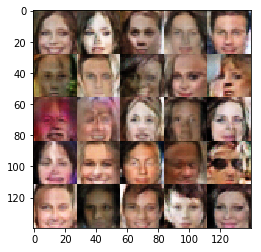

Epoch 2/5 Step 3900... Discriminator Loss: 1.3986... Generator Loss: 0.5080 ... Time spent=0.1317
Epoch 2/5 Step 4000... Discriminator Loss: 1.4407... Generator Loss: 0.5771 ... Time spent=0.1000


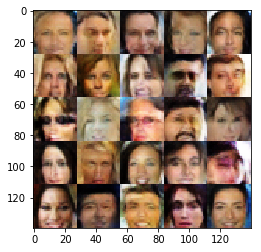

Epoch 3/5 Step 4100... Discriminator Loss: 1.6132... Generator Loss: 0.3623 ... Time spent=0.0995
Epoch 3/5 Step 4200... Discriminator Loss: 1.4889... Generator Loss: 0.4082 ... Time spent=0.1013


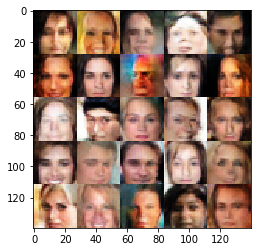

Epoch 3/5 Step 4300... Discriminator Loss: 1.4568... Generator Loss: 0.5847 ... Time spent=0.1156
Epoch 3/5 Step 4400... Discriminator Loss: 1.5483... Generator Loss: 0.4688 ... Time spent=0.0999


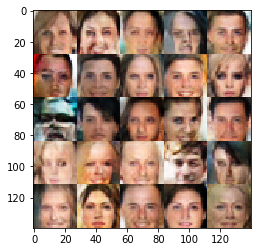

Epoch 3/5 Step 4500... Discriminator Loss: 1.4194... Generator Loss: 0.5746 ... Time spent=0.0984
Epoch 3/5 Step 4600... Discriminator Loss: 1.4198... Generator Loss: 0.5630 ... Time spent=0.1038


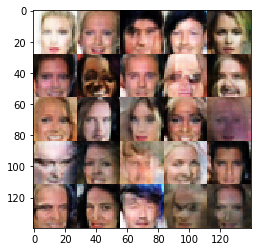

Epoch 3/5 Step 4700... Discriminator Loss: 1.5426... Generator Loss: 0.4076 ... Time spent=0.1160
Epoch 3/5 Step 4800... Discriminator Loss: 1.5949... Generator Loss: 0.3673 ... Time spent=0.1091


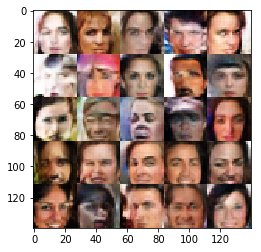

Epoch 3/5 Step 4900... Discriminator Loss: 1.3962... Generator Loss: 0.6454 ... Time spent=0.1139
Epoch 3/5 Step 5000... Discriminator Loss: 1.4107... Generator Loss: 0.7392 ... Time spent=0.1072


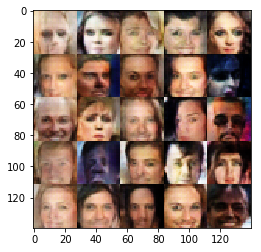

Epoch 3/5 Step 5100... Discriminator Loss: 1.5706... Generator Loss: 0.4088 ... Time spent=0.0936
Epoch 3/5 Step 5200... Discriminator Loss: 1.4653... Generator Loss: 0.5174 ... Time spent=0.0987


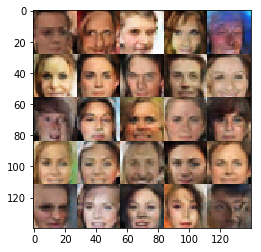

Epoch 3/5 Step 5300... Discriminator Loss: 1.4271... Generator Loss: 0.5635 ... Time spent=0.0966
Epoch 3/5 Step 5400... Discriminator Loss: 1.4888... Generator Loss: 0.4681 ... Time spent=0.0891


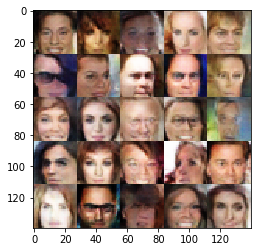

Epoch 3/5 Step 5500... Discriminator Loss: 1.3726... Generator Loss: 0.5901 ... Time spent=0.1116
Epoch 3/5 Step 5600... Discriminator Loss: 1.4165... Generator Loss: 0.5855 ... Time spent=0.1001


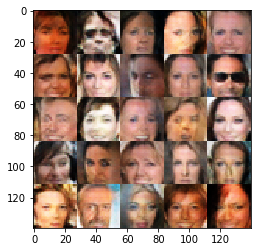

Epoch 3/5 Step 5700... Discriminator Loss: 1.5594... Generator Loss: 0.4111 ... Time spent=0.1037
Epoch 3/5 Step 5800... Discriminator Loss: 1.5006... Generator Loss: 0.9062 ... Time spent=0.1003


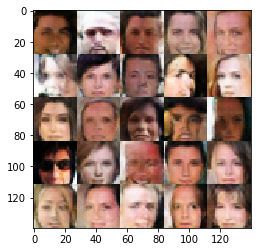

Epoch 3/5 Step 5900... Discriminator Loss: 1.5096... Generator Loss: 0.4093 ... Time spent=0.1095
Epoch 3/5 Step 6000... Discriminator Loss: 1.3889... Generator Loss: 0.5914 ... Time spent=0.1008


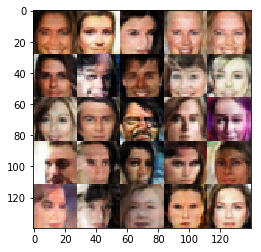

Epoch 4/5 Step 6100... Discriminator Loss: 1.4460... Generator Loss: 0.5681 ... Time spent=0.1216
Epoch 4/5 Step 6200... Discriminator Loss: 1.3788... Generator Loss: 0.9509 ... Time spent=0.0862


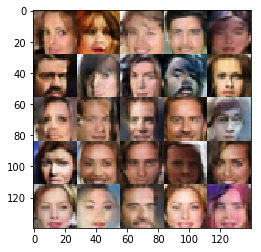

Epoch 4/5 Step 6300... Discriminator Loss: 1.4986... Generator Loss: 0.5695 ... Time spent=0.1020
Epoch 4/5 Step 6400... Discriminator Loss: 1.5138... Generator Loss: 0.4498 ... Time spent=0.1000


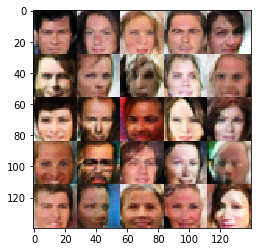

Epoch 4/5 Step 6500... Discriminator Loss: 1.5044... Generator Loss: 0.5409 ... Time spent=0.1104
Epoch 4/5 Step 6600... Discriminator Loss: 1.4539... Generator Loss: 0.4514 ... Time spent=0.1061


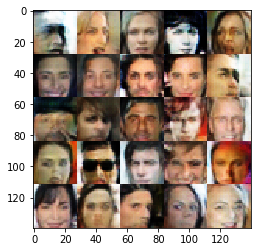

Epoch 4/5 Step 6700... Discriminator Loss: 1.4353... Generator Loss: 0.5288 ... Time spent=0.1001
Epoch 4/5 Step 6800... Discriminator Loss: 1.4249... Generator Loss: 0.5623 ... Time spent=0.1064


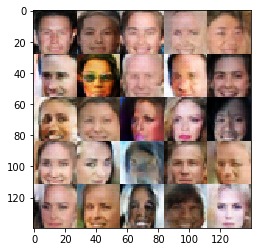

Epoch 4/5 Step 6900... Discriminator Loss: 1.4507... Generator Loss: 0.5345 ... Time spent=0.0978
Epoch 4/5 Step 7000... Discriminator Loss: 1.4629... Generator Loss: 0.4525 ... Time spent=0.1000


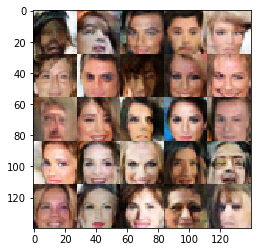

Epoch 4/5 Step 7100... Discriminator Loss: 1.4314... Generator Loss: 0.5212 ... Time spent=0.1045
Epoch 4/5 Step 7200... Discriminator Loss: 1.3810... Generator Loss: 0.5942 ... Time spent=0.0937


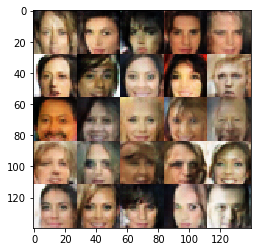

Epoch 4/5 Step 7300... Discriminator Loss: 1.4354... Generator Loss: 0.5433 ... Time spent=0.1029
Epoch 4/5 Step 7400... Discriminator Loss: 1.4188... Generator Loss: 0.5509 ... Time spent=0.1018


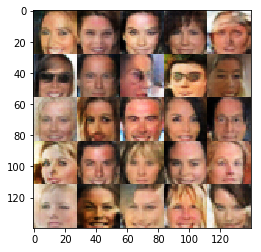

Epoch 4/5 Step 7500... Discriminator Loss: 1.5137... Generator Loss: 0.4477 ... Time spent=0.1197
Epoch 4/5 Step 7600... Discriminator Loss: 1.4216... Generator Loss: 0.6208 ... Time spent=0.1095


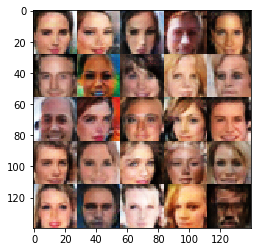

Epoch 4/5 Step 7700... Discriminator Loss: 1.2987... Generator Loss: 0.7679 ... Time spent=0.1155
Epoch 4/5 Step 7800... Discriminator Loss: 1.4812... Generator Loss: 0.6434 ... Time spent=0.1003


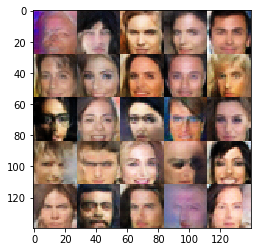

Epoch 4/5 Step 7900... Discriminator Loss: 1.5144... Generator Loss: 0.4818 ... Time spent=0.1048
Epoch 4/5 Step 8000... Discriminator Loss: 1.5273... Generator Loss: 0.6178 ... Time spent=0.0998


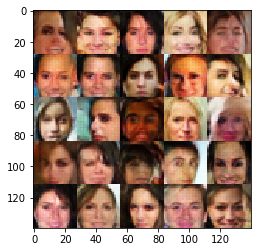

Epoch 4/5 Step 8100... Discriminator Loss: 1.4768... Generator Loss: 0.6253 ... Time spent=0.1109
Epoch 5/5 Step 8200... Discriminator Loss: 1.4085... Generator Loss: 0.5428 ... Time spent=0.1040


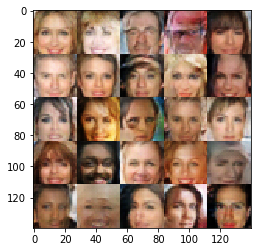

Epoch 5/5 Step 8300... Discriminator Loss: 1.6213... Generator Loss: 0.3824 ... Time spent=0.1050
Epoch 5/5 Step 8400... Discriminator Loss: 1.2832... Generator Loss: 0.9832 ... Time spent=0.1141


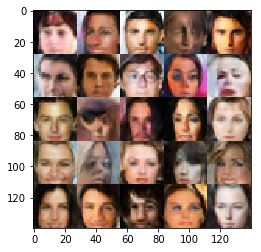

Epoch 5/5 Step 8500... Discriminator Loss: 1.3545... Generator Loss: 0.6783 ... Time spent=0.1082
Epoch 5/5 Step 8600... Discriminator Loss: 1.4311... Generator Loss: 0.6407 ... Time spent=0.1161


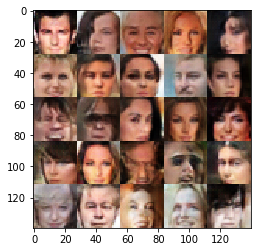

Epoch 5/5 Step 8700... Discriminator Loss: 1.4892... Generator Loss: 0.4802 ... Time spent=0.1031
Epoch 5/5 Step 8800... Discriminator Loss: 1.4008... Generator Loss: 0.6944 ... Time spent=0.0985


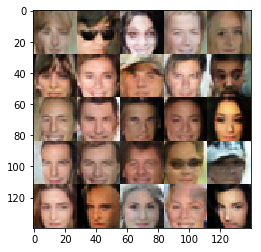

Epoch 5/5 Step 8900... Discriminator Loss: 1.4342... Generator Loss: 0.5035 ... Time spent=0.1003
Epoch 5/5 Step 9000... Discriminator Loss: 1.4229... Generator Loss: 0.5133 ... Time spent=0.0995


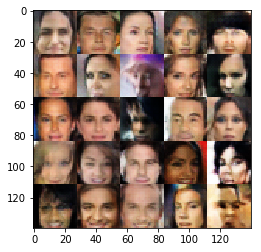

Epoch 5/5 Step 9100... Discriminator Loss: 1.4713... Generator Loss: 0.4948 ... Time spent=0.0985
Epoch 5/5 Step 9200... Discriminator Loss: 1.5331... Generator Loss: 0.4976 ... Time spent=0.0973


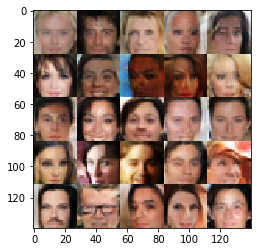

Epoch 5/5 Step 9300... Discriminator Loss: 1.6082... Generator Loss: 0.3845 ... Time spent=0.1138
Epoch 5/5 Step 9400... Discriminator Loss: 1.4378... Generator Loss: 0.5776 ... Time spent=0.1198


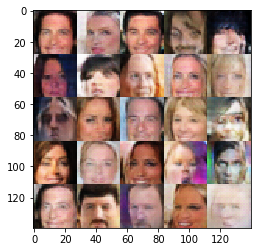

Epoch 5/5 Step 9500... Discriminator Loss: 1.4820... Generator Loss: 0.5715 ... Time spent=0.1003
Epoch 5/5 Step 9600... Discriminator Loss: 1.4897... Generator Loss: 0.4447 ... Time spent=0.1001


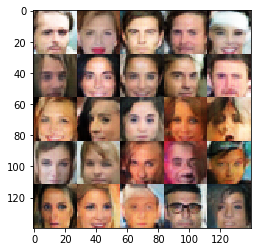

Epoch 5/5 Step 9700... Discriminator Loss: 1.0716... Generator Loss: 0.7990 ... Time spent=0.1052
Epoch 5/5 Step 9800... Discriminator Loss: 1.3051... Generator Loss: 0.6172 ... Time spent=0.0939


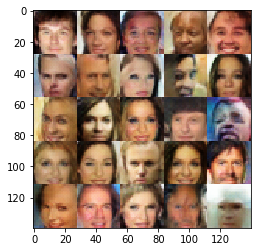

Epoch 5/5 Step 9900... Discriminator Loss: 1.3884... Generator Loss: 0.5398 ... Time spent=0.1059
Epoch 5/5 Step 10000... Discriminator Loss: 1.3566... Generator Loss: 0.6013 ... Time spent=0.1159


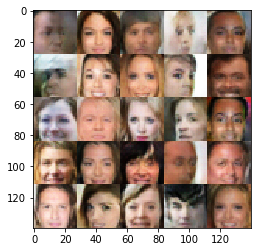

Epoch 5/5 Step 10100... Discriminator Loss: 1.3995... Generator Loss: 0.5143 ... Time spent=0.1098


In [27]:
batch_size = 100
z_dim = 100
learning_rate = .001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 5

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.